<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Coding AdaBoost from Scratch

_Authors: Kiefer Katovich (SF)_

---

> **Note:** This is intended to be a codealong with the instructor.

Below we will be coding the AdaBoost algorithm from scratch, then visualizing the results as weak learners are chained onto the meta-estimator.


In [2]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

## AdaBoost algorithm pt. 1

---

Recall,

### $$ AdaBoost(X) = sign\left(\sum_{t=1}^T\alpha_t h_t(X)\right) $$

where

$AdaBoost(X)$ is the classification predictions for $y$ using predictor matrix $X$

$T$ is the set of "weak learners"

$\alpha_t$ is the contribution weight for weak learner $t$

$h_t(X)$ is the prediction of weak learner $t$

and $y$ is binary **with values -1 and 1**

### 1. Write the AdaBoost estimator function based on the algorithm described above.

Your function will need arguments:
- `X`, the design matrix
- `estimators`, the weak learners
- `alphas`, the contribution weight of each weak learner

We will be using this later.

In [1]:
def adaboost(X, estimators, alphas):
    yhat = np.zeros(X.shape[0])
    for alpha, est in zip(alphas, estimators):
        prediction = [1 if y == 1 else -1 for y in est.predict(X)]
        prediction = np.array(prediction) * alpha
        yhat = yhat + prediction
    yhat = np.sign(yhat)
    yhat = np.array([1 if y == 1 else 0 for y in yhat])
    return yhat
    

## AdaBoost algorithm pt. 2

---

The weak learner classifiers are trained sequentially.  After each fit, the importance weights on each observation need to be updated. AdaBoost, like all boosting ensemble methods, focuses the next model's fit on the misclassifications/weaknesses of the prior models.

All training examples start with equal importance weighting. When we finish training a classifier, we update the importance weighting of the classifier itself represented by alpha $\alpha$.

### $$ \alpha_t = \frac{1}{2}ln \left(\frac{1-\epsilon_t}{\epsilon_t}\right) \text{where } \epsilon_t < 1$$

Where $\epsilon_t$ is the misclassification rate for the current classifier:

### $$ \epsilon_t = \frac{\text{misclassifications}_t}{\text{observations}_t} $$



### 2. Write a function to calculate the alpha weight.

The function will take arguments:
- `y`, the vector of true target values
- `y_hat`, the vector of predictions

In [4]:
def calculate_alpha(y_true, predictions):
    error_rate = 1. - np.mean(y_true == predictions)
    return np.log((1. - error_rate) / error_rate) * 0.5

## AdaBoost algorithm pt. 3

---

Adaboost sets up a weight vector on the observations, denoted $D_t$ where $t$ is the current model iteration. $D_t$ is a probability distribution that determines how likely it is a given observation will be selected as part of the training set for the current estimator.

The $\alpha$ weighting of the last fit estimator is used in the equation for the weighting distribution. The update equation is:

### $$ D_{t+1}(i) = D_t(i) e^{-\alpha_t y_i h_t(x_i)} $$

Where $i$ is the vector of observation indices and $x_i$ is the observation at the index. $y_i$ is the target.

$h_t$ is the previous model fit in the boosting chain.

And then divide the weights by the sum of weights to normalize them, ensuring that they sum to 1 and form a probability distribution:

### $$ D_{t+1}(i) = \frac{D_{t+1}(i)}{\sum_{i=1}^N D_{t+1}(i)}$$


### 3. Write a function to update the importance weights

The function will take arguments:
- `X`, the design matrix
- `y`, the vector of target values
- `current_D`, the current weights on observations
- `alpha`, the weight on the current estimator
- `estimator`, the current weak learner

In [5]:
def update_importance_weights(X, ytrue, current_D, alpha, estimator):
    y_true_signed = np.array([1 if y == 1 else -1 for y in ytrue])
    y_hat_signed = np.array([1 if y == 1 else -1 for y in estimator.predict(X)])
    
    updated_D = current_D * np.exp((-alpha * y_true_signed * y_hat_signed))
    updated_D = updated_D / np.sum(updated_D)
    return updated_D

### 4. Write a function that will sample observations according to weightings

The function will take arguments:
- `X`, the design matrix
- `y`, the vector of target values
- `D`, the probability weights on observations

In [6]:
def sample_with_weights(X, y, D):
    indices = np.arange(X.shape[0])
    random_indices = np.random.choice(indices, size=X.shape[0], replace=True, p=D)
    return X[random_indices, :], y[random_indices]

### 5. Create some fake data (provided)

In [7]:
moons = make_moons(n_samples=30, noise=0.75)
X, y = moons
X = StandardScaler().fit_transform(X)

x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))

### 7. Write a function to plot the current AdaBoost iteration (provided)

In [8]:
def plot_adaboost(X, y, xx, xy, clf, D):
    from matplotlib.colors import ListedColormap

    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    fig, ax = plt.subplots(figsize=(9,7))
    
    ss = [30 + 2500*w for w in D]

    cm_dark = ListedColormap(['#1F77B4', '#FF7F0E'])
    cm_light = ListedColormap(['#729ECE', '#FF9E4A'])
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_dark, s=ss)

    ax.contourf(xx, yy, Z, cmap=cm_light, alpha=.25)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

    plt.show()

### 8. Iterate the AdaBoost algorithm through 10 iterations, with each iteration adding a new weak learner

This will need to follow the procedure outlined in the algorithm formulas above.

You will need to keep track of:
- `D`, the probability weights for sampling observations
- a list of estimators (weak learners)
- a list of alpha weightings on each weak learner

At each iteration, plot AdaBoost with the function provided above and calculate the accuracy of the entire ensemble model.

ITERATION: 0
Accuracy: 0.833333333333
ITERATION: 1
Accuracy: 0.833333333333


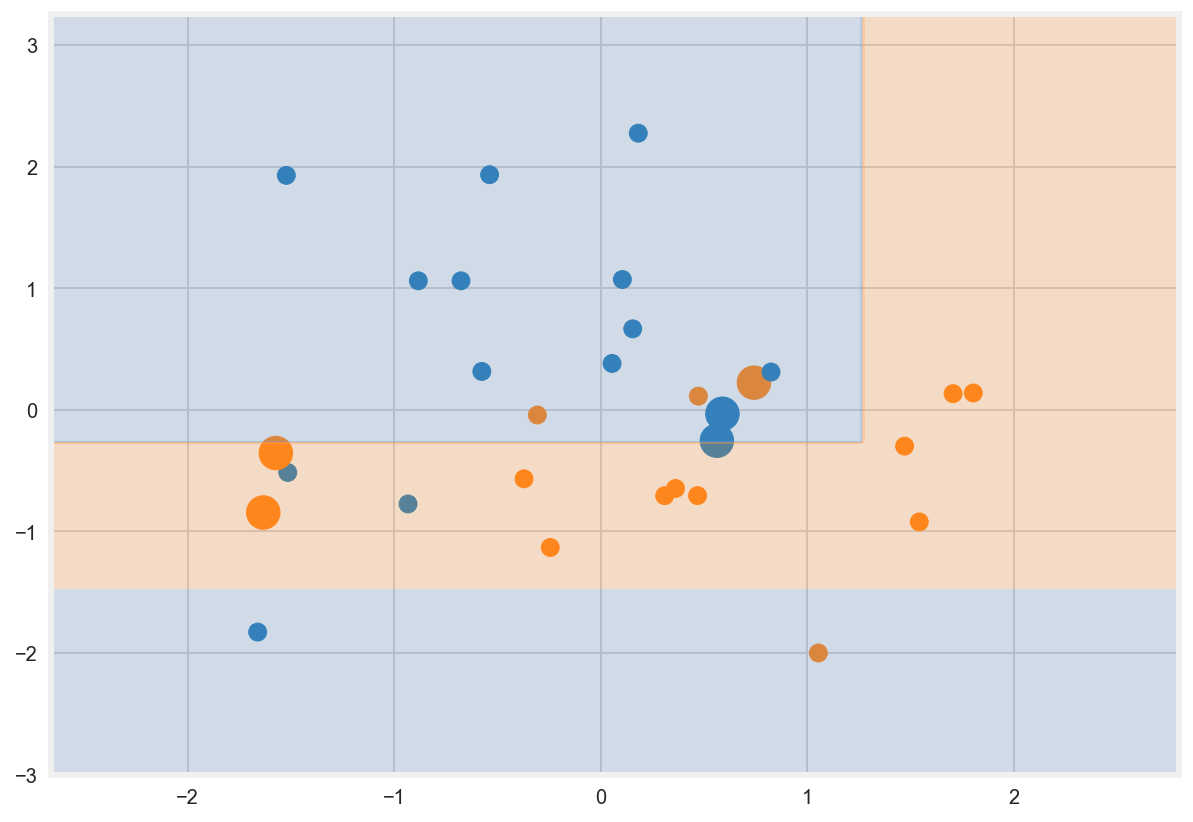

ITERATION: 2
Accuracy: 0.833333333333


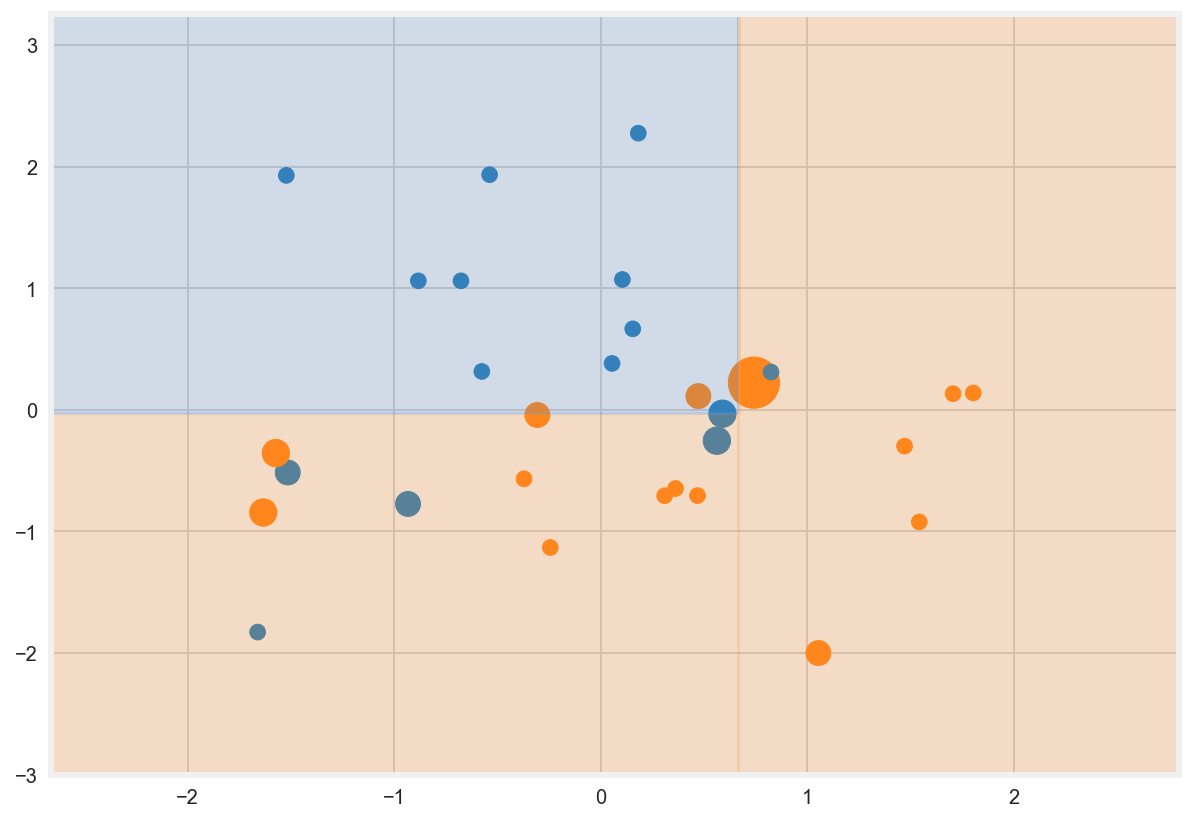

ITERATION: 3
Accuracy: 0.833333333333


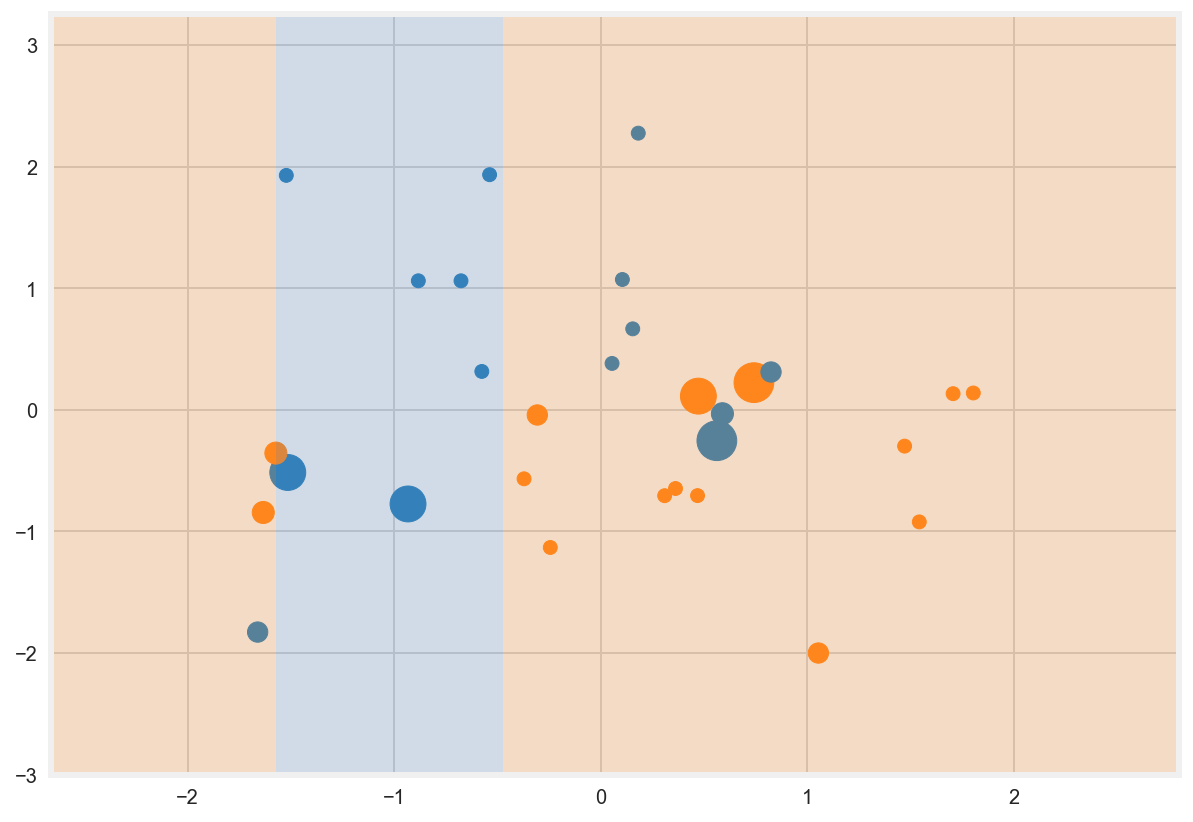

ITERATION: 4
Accuracy: 0.833333333333


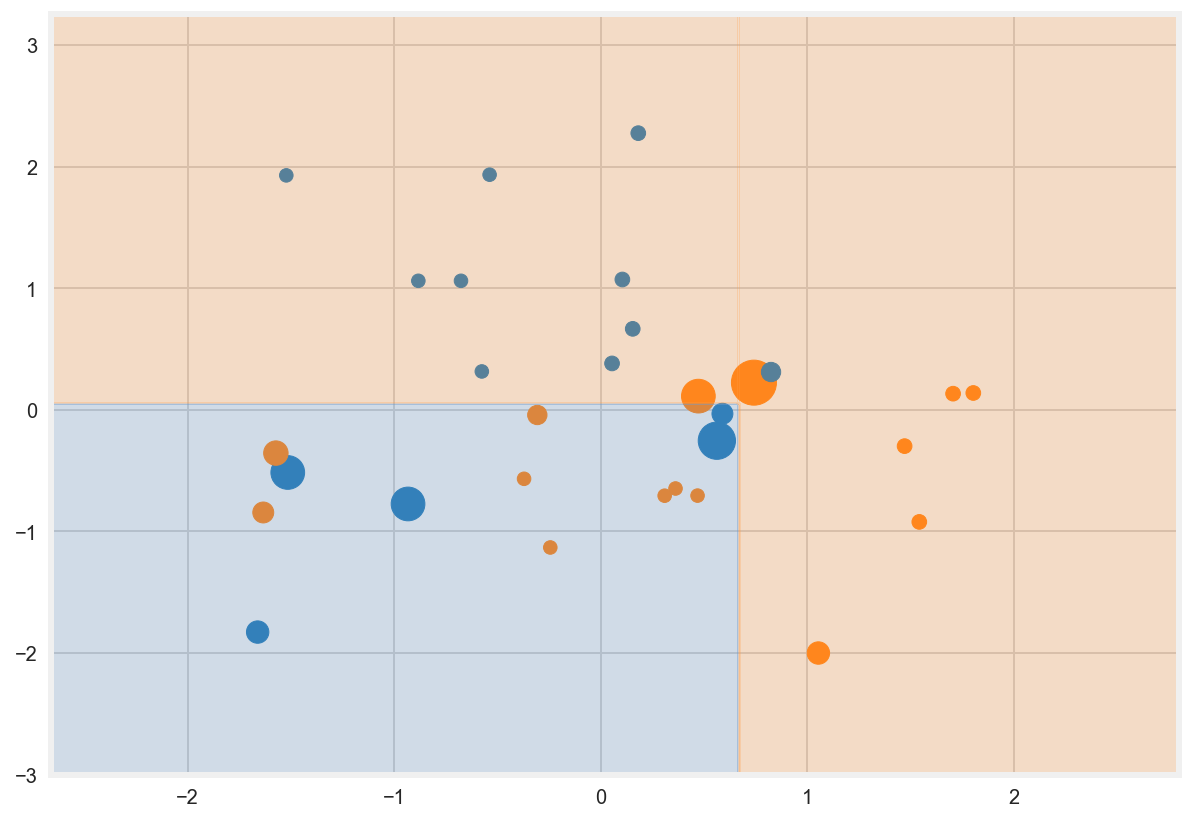

ITERATION: 5
Accuracy: 0.866666666667


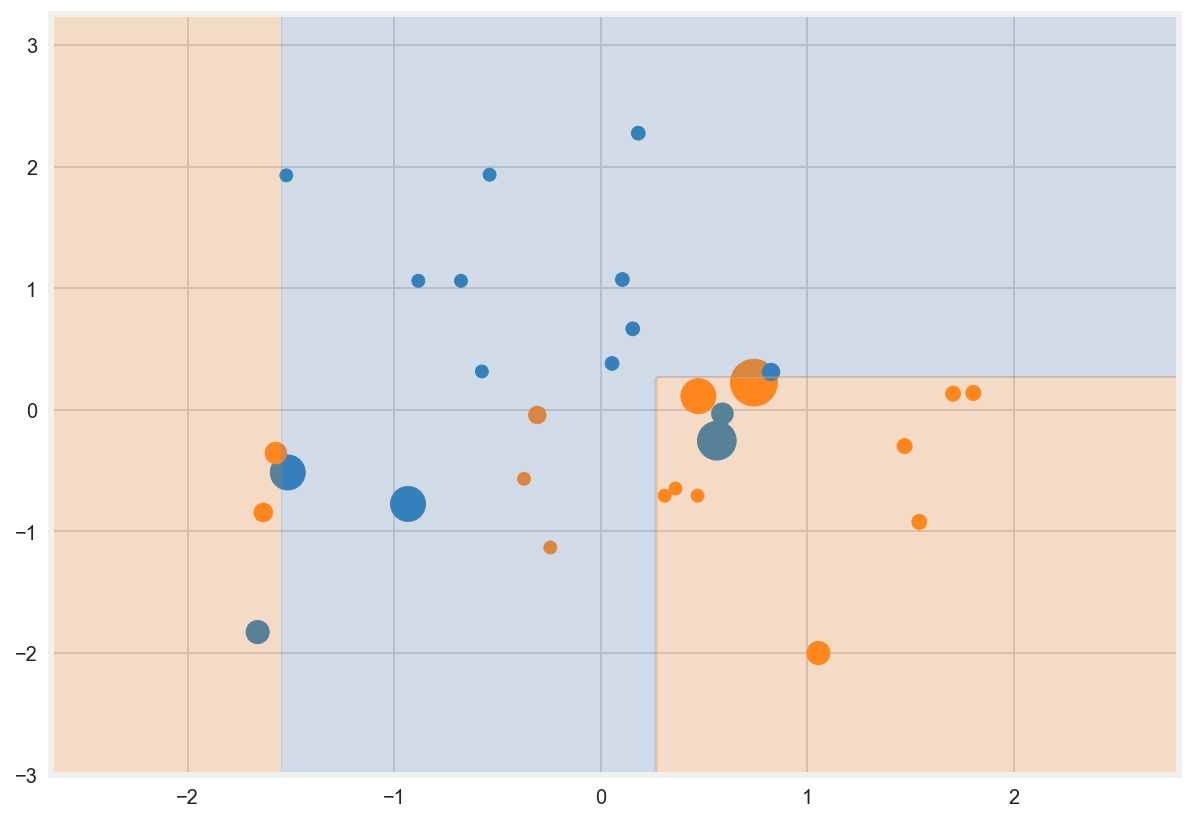

ITERATION: 6
Accuracy: 0.8


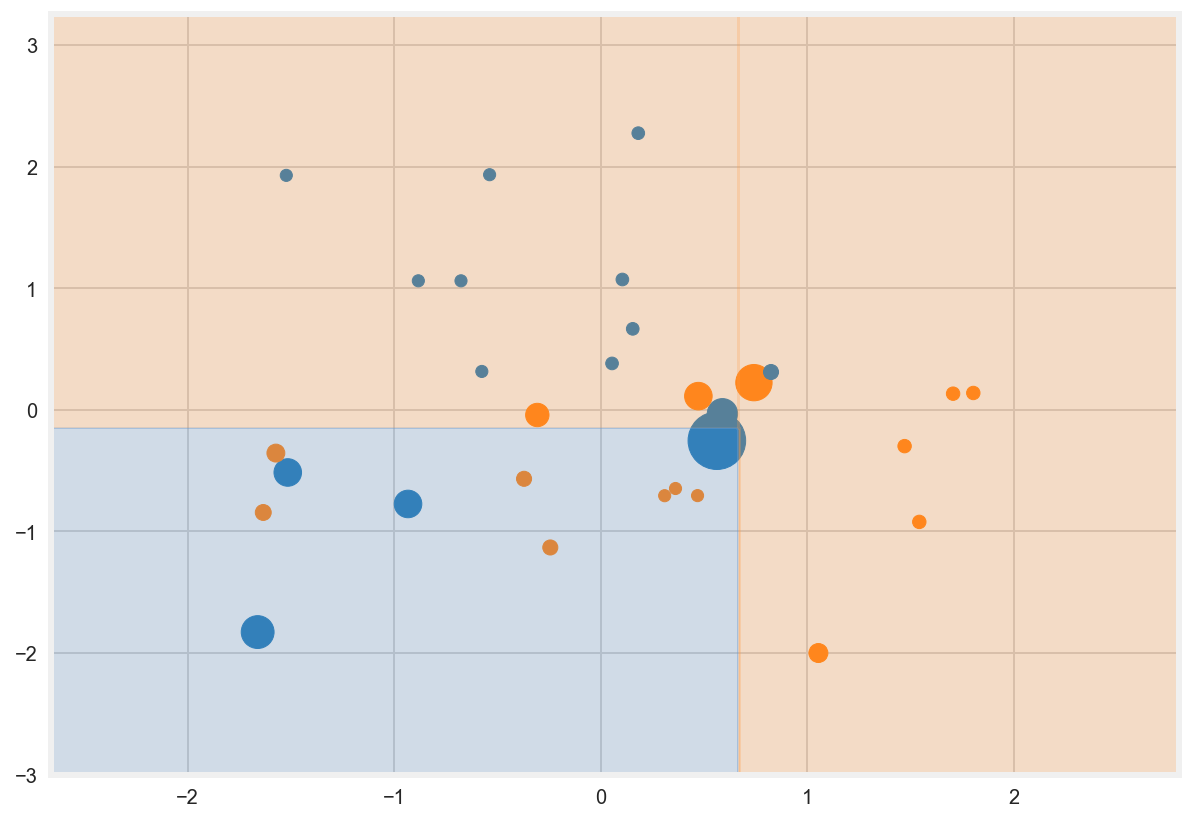

ITERATION: 7
Accuracy: 0.833333333333


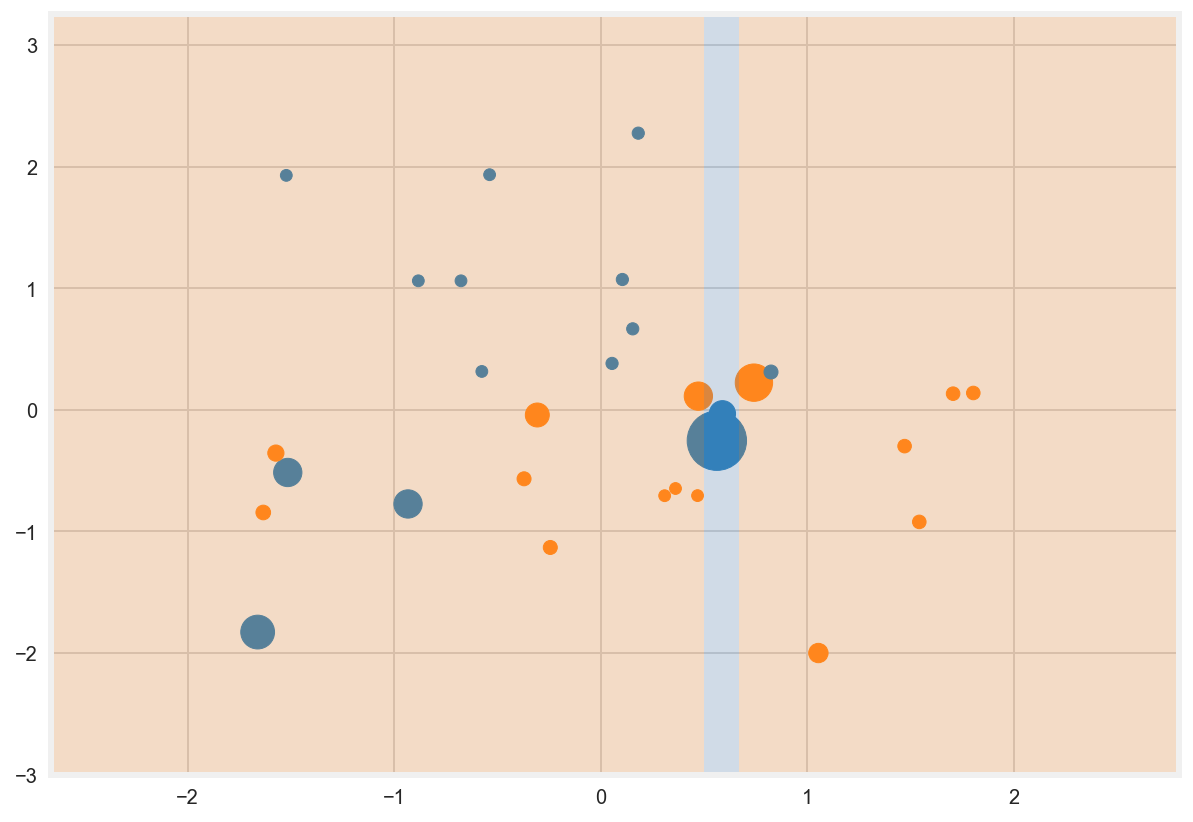

ITERATION: 8
Accuracy: 0.866666666667


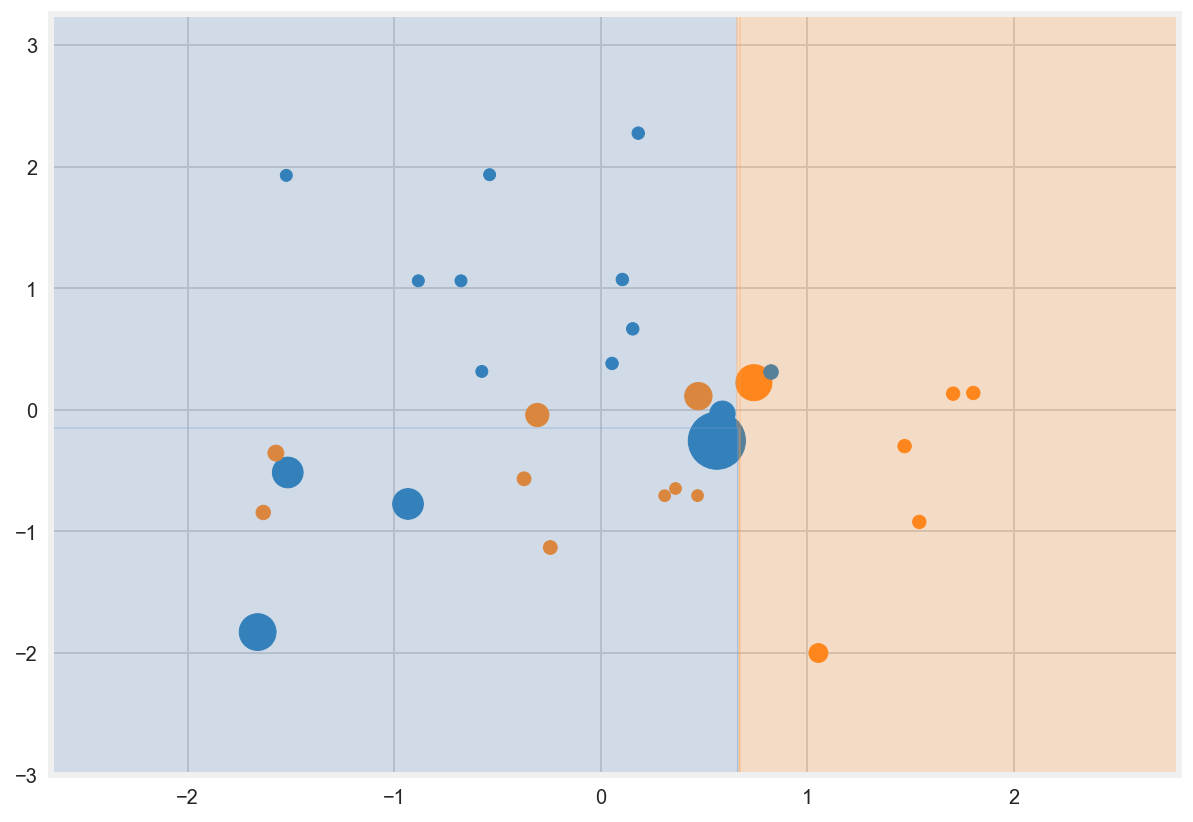

ITERATION: 9
Accuracy: 0.866666666667


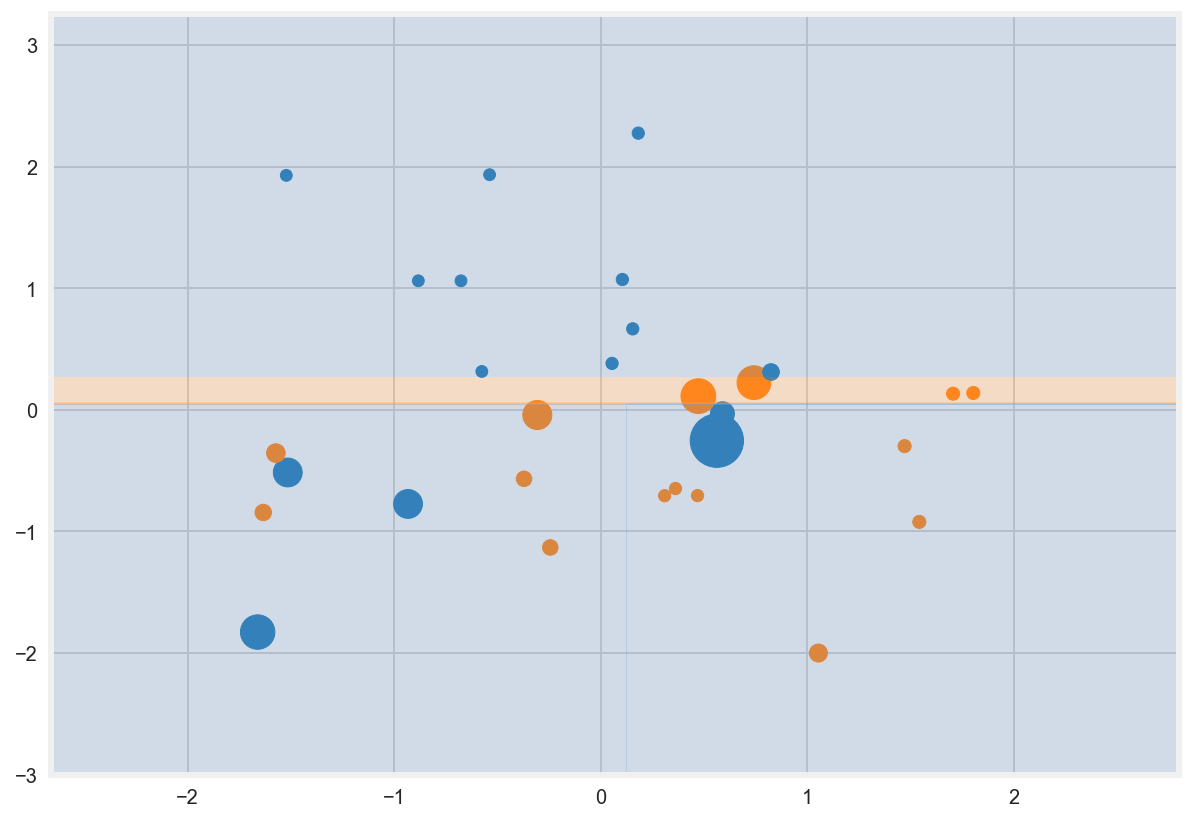

In [9]:
n_estimators = 10
D = np.ones(len(y))/len(y)

estimators = []
alphas = []
Ds = []

for i in range(n_estimators):
    print 'ITERATION:', i
    X_boot, y_boot = sample_with_weights(X, y, D)
    dtc = DecisionTreeClassifier(max_depth=2)
    dtc.fit(X_boot, y_boot)
    
    yhat = dtc.predict(X)
    alpha = calculate_alpha(y, yhat)
    
    D = update_importance_weights(X, y, D, alpha, dtc)
    
    estimators.append(dtc)
    alphas.append(alpha)
    Ds.append(D)
    
    ada_predictions = adaboost(X, estimators, alphas)
    print 'Accuracy:', np.mean(y == ada_predictions)
    
    if i > 0:
        plot_adaboost(X, y, xx, yy, dtc, Ds[-2])